In [ ]:
from google.colab import drive
drive.mount('/drive', force_remount=True)

Mounted at /drive


In [ ]:
import os
import sys
import random
import warnings
import numpy as np
import pandas as pd
import cv2
from PIL import Image
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.model_selection import train_test_split
import torch 
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms
from torch import optim
from torch.utils.data import Dataset
from tqdm.auto import tqdm
from tqdm import trange
from google.colab.patches import cv2_imshow

In [ ]:
img_width=160
img_height=160
img_channels=3
width_out=160
height_out=160
batch_size = 32
train_path='/drive/MyDrive/Data_rings/Training/'
val_path='/drive/MyDrive/Data_rings/Validation/'
test_path='/drive/MyDrive/Data_rings/Testing/'
shuffle = False

# **Data Loading**

In [ ]:
train_df = pd.DataFrame(os.listdir(train_path+'Cine/'))
val_df = pd.DataFrame(os.listdir(val_path+'Cine/'))
test_df = pd.DataFrame(os.listdir(test_path+'Cine/'))

In [ ]:
class Train_DataLoad(Dataset):
  def __init__(self, dataframe, rootdir, transform=None):
    self.dataframe = dataframe
    self.rootdir = rootdir
    self.transform=transform

  def __len__(self):
    return len(self.dataframe)

  def __getitem__(self, idx):
    if torch.is_tensor(idx):
      idx = idx.tolist()
    img_name = os.path.join(self.rootdir+'Cine/', self.dataframe.iloc[idx, 0])
    image = Image.open(img_name)
    mask_name = os.path.join(self.rootdir+'Mask/', self.dataframe.iloc[idx, 0])
    mask = Image.open(mask_name)
    mask_transform = transforms.Compose([transforms.ToTensor(), transforms.Resize((224, 224))])
    if self.transform:
      image = self.transform(image)
    mask = mask_transform(mask)
    return (image, mask)


class Val_DataLoad(Dataset):
  def __init__(self, dataframe, rootdir, transform=None):
    self.dataframe = dataframe
    self.rootdir = rootdir
    self.transform=transform

  def __len__(self):
    return len(self.dataframe)

  def __getitem__(self, idx):
    if torch.is_tensor(idx):
      idx = idx.tolist()
    img_name = os.path.join(self.rootdir+'Cine/', self.dataframe.iloc[idx, 0])
    image = Image.open(img_name)
    mask_name = os.path.join(self.rootdir+'Mask/', self.dataframe.iloc[idx, 0])
    mask = Image.open(mask_name)
    mask_transform = transforms.Compose([transforms.ToTensor(), transforms.Resize((224, 224))])
    image = np.dstack((image, image, image))
    if self.transform:
      image = self.transform(image)
    mask = mask_transform(mask)
    return (image, mask)



def data_prep(root_dir_training, root_dir_testing, train_df, test_df, batch_size, shuffle):
    train_set = Train_DataLoad(train_df, root_dir_training, transform = transforms.Compose([transforms.ToTensor(), transforms.Grayscale(3), transforms.Resize((224, 224))]))
    train_loader = torch.utils.data.DataLoader(dataset = train_set, batch_size = batch_size, shuffle=shuffle)
    test_set = Val_DataLoad(test_df, root_dir_testing, transform = transforms.Compose([transforms.ToTensor(), transforms.Grayscale(3), transforms.Resize((224, 224))]))
    test_loader = torch.utils.data.DataLoader(dataset = test_set, batch_size = batch_size, shuffle=shuffle)
    return train_loader, test_loader

In [ ]:
train_loader, val_loader = data_prep(train_path, val_path, train_df, val_df, batch_size, shuffle)

In [ ]:
class Test_DataLoad(Dataset):
  def __init__(self, dataframe, rootdir, transform=None):
    self.dataframe = dataframe
    self.rootdir = rootdir
    self.transform=transform

  def __len__(self):
    return len(self.dataframe)

  def __getitem__(self, idx):
    if torch.is_tensor(idx):
      idx = idx.tolist()
    img_name = os.path.join(self.rootdir+'Cine/', self.dataframe.iloc[idx, 0])
    image = Image.open(img_name)
    if self.transform:
      image = self.transform(image)
    return (image)

In [ ]:
test_set = Test_DataLoad(test_df, '/drive/MyDrive/Data_rings/Testing/', transform = transforms.Compose([transforms.ToTensor(), transforms.Grayscale(3), transforms.Resize((224, 224))]))
test_loader = torch.utils.data.DataLoader(dataset = test_set, batch_size = batch_size, shuffle=shuffle)

# **UNet from Scratch**

In [ ]:
class UNet(nn.Module):
  def __init__(self):
    super(UNet, self).__init__()

    self.out1=nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1)
    self.out2=nn.BatchNorm2d(32)
    self.out3=nn.ReLU()
    self.out4=nn.Conv2d(32, 32, kernel_size=3, padding=1)
    self.out5=nn.BatchNorm2d(32)
    self.out6=nn.ReLU()
    self.out7=nn.MaxPool2d(2)
    self.out8=nn.Conv2d(32, 64, kernel_size=3, padding=1)
    self.out9=nn.BatchNorm2d(64)
    self.out10=nn.ReLU()
    self.out11=nn.Conv2d(64, 64, kernel_size=3, padding=1)
    self.out12=nn.BatchNorm2d(64)
    self.out13=nn.ReLU()
    self.out14=nn.MaxPool2d(2)
    self.out15=nn.Conv2d(64, 128, kernel_size=3, padding=1)
    self.out16=nn.BatchNorm2d(128)
    self.out17=nn.ReLU()
    self.out18=nn.Conv2d(128, 128, kernel_size=3, padding=1)
    self.out19=nn.BatchNorm2d(128)
    self.out20=nn.ReLU()
    self.out21=nn.MaxPool2d(2)
    self.out22=nn.Conv2d(128, 256, kernel_size=3, padding=1)
    self.out23=nn.BatchNorm2d(256)
    self.out24=nn.ReLU()
    self.out25=nn.Conv2d(256, 256, kernel_size=3, padding=1)
    self.out26=nn.BatchNorm2d(256)
    self.out27=nn.ReLU()
    self.out28=nn.MaxPool2d(2)
    self.out29=nn.Conv2d(256, 512, kernel_size=3, padding=1)
    self.out30=nn.BatchNorm2d(512)
    self.out31=nn.ReLU()
    self.out32=nn.Conv2d(512, 512, kernel_size=3, padding=1)
    self.out33=nn.BatchNorm2d(512)
    self.out34=nn.ReLU()
    self.out35=nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2)
    self.out36=nn.Conv2d(512, 256, kernel_size=3, padding=1)
    self.out37=nn.BatchNorm2d(256)
    self.out38=nn.ReLU()
    self.out39=nn.Conv2d(256, 256, kernel_size=3, padding=1)
    self.out40=nn.BatchNorm2d(256)
    self.out41=nn.ReLU()
    self.out42=nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
    self.out43=nn.Conv2d(256, 128, kernel_size=3, padding=1)
    self.out44=nn.BatchNorm2d(128)
    self.out45=nn.ReLU()
    self.out46=nn.Conv2d(128, 128, kernel_size=3, padding=1)
    self.out47=nn.BatchNorm2d(128)
    self.out48=nn.ReLU()
    self.out49=nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
    self.out50=nn.Conv2d(128, 64, kernel_size=3, padding=1)
    self.out51=nn.BatchNorm2d(64)
    self.out52=nn.ReLU()
    self.out53=nn.Conv2d(64, 64, kernel_size=3, padding=1)
    self.out54=nn.BatchNorm2d(64)
    self.out55=nn.ReLU()
    self.out56=nn.ConvTranspose2d(64, 32, kernel_size=2, stride=2)
    self.out57=nn.Conv2d(64, 32, kernel_size=3, padding=1)
    self.out58=nn.BatchNorm2d(32)
    self.out59=nn.ReLU()
    self.out60=nn.Conv2d(32, 32, kernel_size=3, padding=1)
    self.out61=nn.BatchNorm2d(32)
    self.out62=nn.ReLU()
    self.out63=nn.Conv2d(32, 1, kernel_size=1, stride=1, padding=0)

  def forward(self, inputs):
    outp1=self.out1(inputs)
    outp2=self.out2(outp1)
    outp3=self.out3(outp2)
    outp4=self.out4(outp3)
    outp5=self.out5(outp4)
    outp6=self.out6(outp5)
    outp7=self.out7(outp6)
    outp8=self.out8(outp7)
    outp9=self.out9(outp8)
    outp10=self.out10(outp9)
    outp11=self.out11(outp10)
    outp12=self.out12(outp11)
    outp13=self.out13(outp12)
    outp14=self.out14(outp13)
    outp15=self.out15(outp14)
    outp16=self.out16(outp15)
    outp17=self.out17(outp16)
    outp18=self.out18(outp17)
    outp19=self.out19(outp18)
    outp20=self.out20(outp19)
    outp21=self.out21(outp20)
    outp22=self.out22(outp21)
    outp23=self.out23(outp22)
    outp24=self.out24(outp23)
    outp25=self.out25(outp24)
    outp26=self.out26(outp25)
    outp27=self.out27(outp26)
    outp28=self.out28(outp27)
    outp29=self.out29(outp28)
    outp30=self.out30(outp29)
    outp31=self.out31(outp30)
    outp32=self.out32(outp31)
    outp33=self.out33(outp32)
    outp34=self.out34(outp33)
    outp35=self.out35(outp34)

    diffY = outp27.size()[2] - outp35.size()[2]
    diffX = outp27.size()[3] - outp35.size()[3]

    outp35 = F.pad(outp35, [diffX // 2, diffX - diffX // 2,
                        diffY // 2, diffY - diffY // 2])
    x = torch.cat([outp27, outp35], dim=1)

    outp36=self.out36(x)
    outp37=self.out37(outp36)
    outp38=self.out38(outp37)
    outp39=self.out39(outp38)
    outp40=self.out40(outp39)
    outp41=self.out41(outp40)
    outp42=self.out42(outp41)
    
    diffY = outp20.size()[2] - outp42.size()[2]
    diffX = outp20.size()[3] - outp42.size()[3]

    outp42 = F.pad(outp42, [diffX // 2, diffX - diffX // 2,
                        diffY // 2, diffY - diffY // 2])
    x = torch.cat([outp20, outp42], dim=1)

    outp43=self.out43(x)
    outp44=self.out44(outp43)
    outp45=self.out45(outp44)
    outp46=self.out46(outp45)
    outp47=self.out47(outp46)
    outp48=self.out48(outp47)
    outp49=self.out49(outp48)
    
    diffY = outp13.size()[2] - outp49.size()[2]
    diffX = outp13.size()[3] - outp49.size()[3]

    outp49 = F.pad(outp49, [diffX // 2, diffX - diffX // 2,
                        diffY // 2, diffY - diffY // 2])
    x = torch.cat([outp13, outp49], dim=1)

    outp50=self.out50(x)
    outp51=self.out51(outp50)
    outp52=self.out52(outp51)
    outp53=self.out53(outp52)
    outp54=self.out54(outp53)
    outp55=self.out55(outp54)
    outp56=self.out56(outp55)
    
    diffY = outp6.size()[2] - outp56.size()[2]
    diffX = outp6.size()[3] - outp56.size()[3]

    outp56 = F.pad(outp56, [diffX // 2, diffX - diffX // 2,
                        diffY // 2, diffY - diffY // 2])
    x = torch.cat([outp6, outp56], dim=1)

    outp57=self.out57(x)
    outp58=self.out58(outp57)
    outp59=self.out59(outp58)
    outp60=self.out60(outp59)
    outp61=self.out61(outp60)
    outp62=self.out62(outp61)
    outp63=self.out63(outp62)
    return outp63

In [ ]:
def train(model, trainloader, optimizer, criterion, device):
  model.train()

  running_loss = 0.0
  for cine, mask in tqdm(trainloader):
    optimizer.zero_grad()
    cine = cine.to(device)
    mask = mask.to(device)
  
    outputs = model(cine)
    out_flatten = nn.Flatten()
    mask_flatten = nn.Flatten()
    loss=criterion(out_flatten(outputs), mask_flatten(mask))
    running_loss+=loss.item()*cine.size(0)
    loss.backward()
    optimizer.step()
  
  epoch_loss = running_loss/len(trainloader.dataset)
  
  return epoch_loss 

In [ ]:
def eval(model, testloader, criterion, device):
  model.eval()

  with torch.no_grad():
      running_loss = 0.0
      for cine, mask in tqdm(testloader):
        
        cine = cine.to(device)
        mask = mask.to(device)
      
        outputs = model(cine)
        out_flatten = nn.Flatten()
        mask_flatten = nn.Flatten()
        loss=criterion(out_flatten(outputs), mask_flatten(mask))
        running_loss+=loss.item()*cine.size(0)
      
      epoch_loss = running_loss/len(testloader.dataset)
  
  return epoch_loss 

In [ ]:
def run(train_loader, val_loader, epochs):
    model = UNet()
    criterion=nn.CrossEntropyLoss()
    optimizer=optim.Adam(model.parameters(), lr=0.001)
    device = torch.device("cuda" if torch.cuda.is_available() else 'cpu')
    model.to(device)

    for epoch in range(epochs):
        train_loss = train(model, train_loader, optimizer, criterion, device)
        val_loss = eval(model, val_loader, criterion, device)
        if epoch==0:
          best_loss = val_loss
          torch.save(model.state_dict(), os.path.join('/drive/MyDrive/Data_rings/Models/', '{0:0=2f}.pth'.format(best_loss)))

        else:
          if val_loss<best_loss:
            best_loss = val_loss
            torch.save(model.state_dict(), os.path.join('/drive/MyDrive/Data_rings/Models/', '{0:0=2f}.pth'.format(best_loss)))


In [ ]:
run(train_loader, val_loader, 5)

In [ ]:
def inference(test_loader):
    model = UNet()
    device = torch.device("cuda" if torch.cuda.is_available() else 'cpu')
    model.to(device)
    outputs=[]
    model.load_state_dict(torch.load('/drive/MyDrive/Data_rings/Models/6790.218959.pth'))
    with torch.no_grad():
      for cine in tqdm(test_loader):
          cine = cine.to(device)
          #cv2_imshow(cine[0][0].detach().numpy().reshape((224, 224)))
          mask = model(cine)
          outputs.append(mask)
      

    return outputs

In [ ]:
output = inference(test_loader)

  0%|          | 0/1 [00:00<?, ?it/s]

In [ ]:
len(output)

1

In [ ]:
output[0].shape

torch.Size([32, 1, 224, 224])

In [ ]:
output[0][0].detach().numpy().reshape((224, 224, 1)).shape

(224, 224, 1)

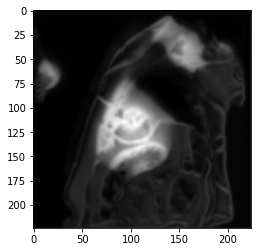

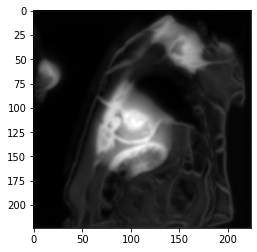

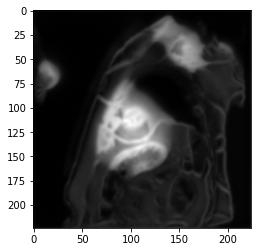

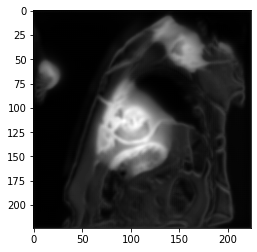

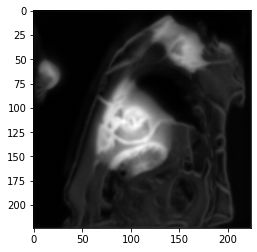

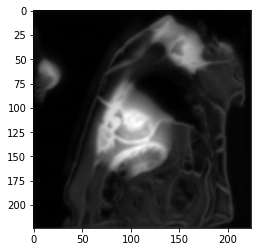

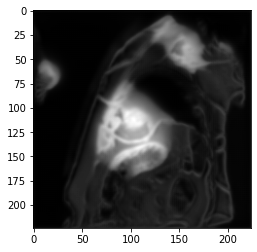

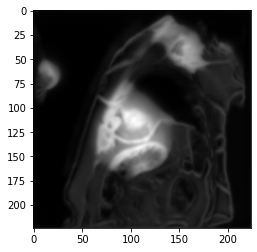

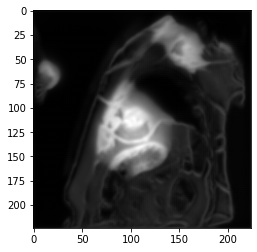

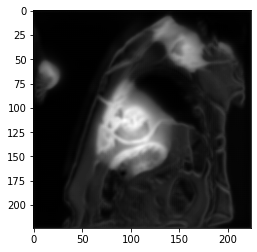

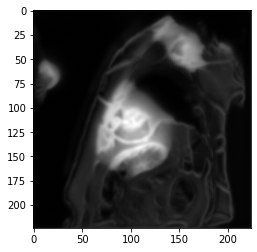

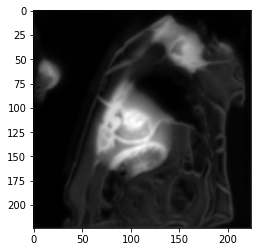

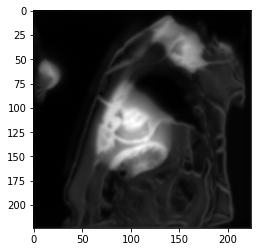

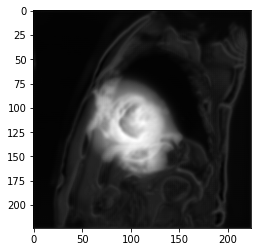

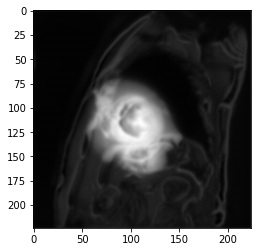

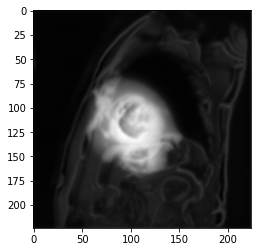

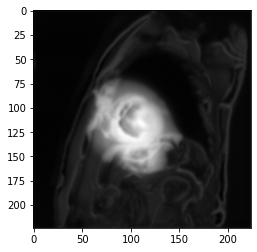

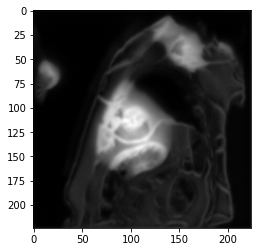

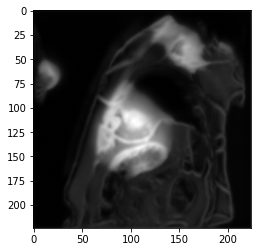

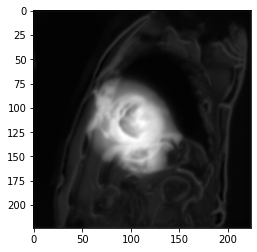

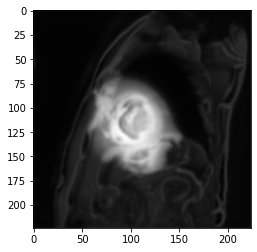

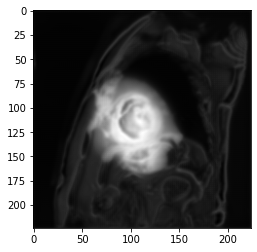

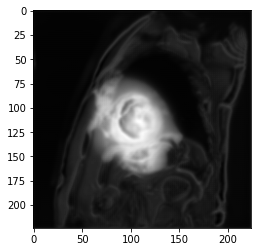

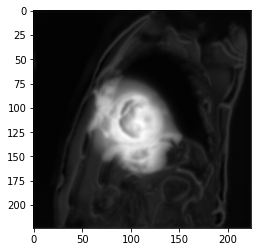

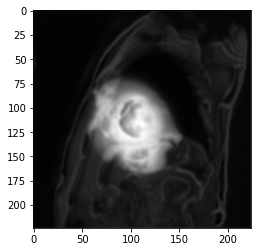

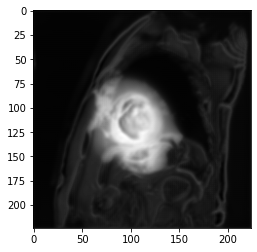

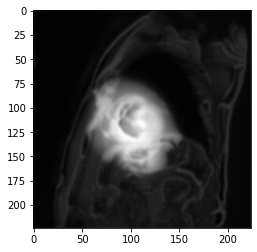

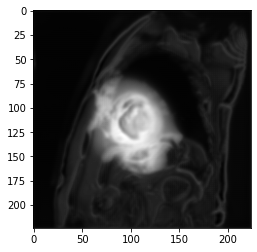

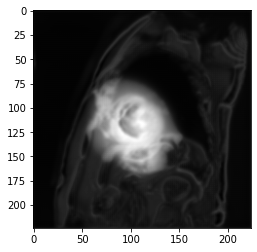

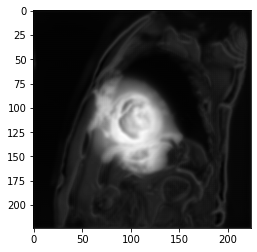

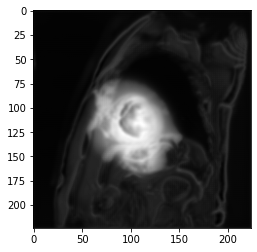

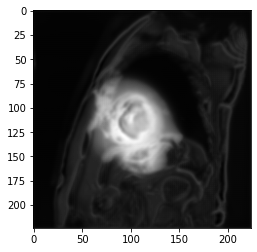

In [ ]:
for out in output[0]:
  #print(out.numpy()[0].shape)
  plt.imshow(out.numpy()[0], cmap='gray')
  plt.show()

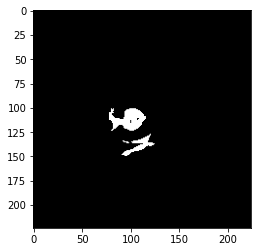

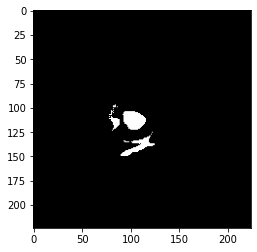

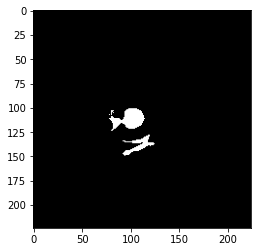

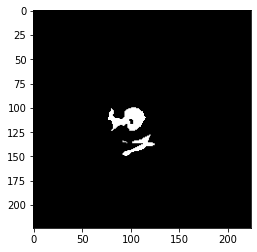

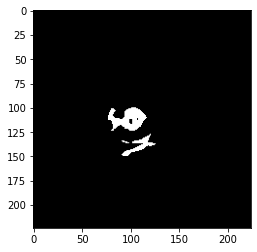

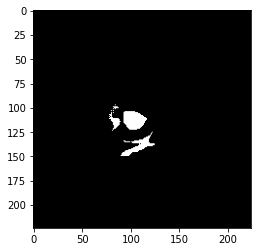

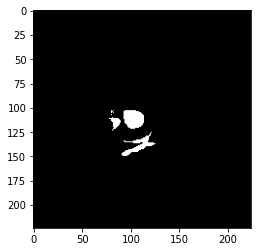

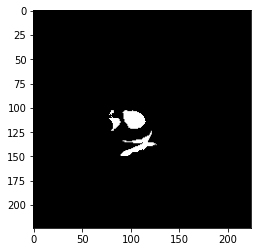

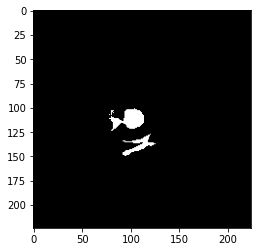

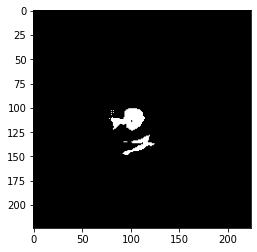

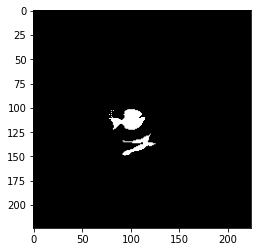

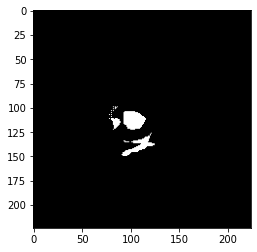

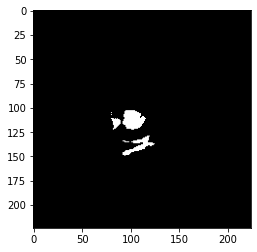

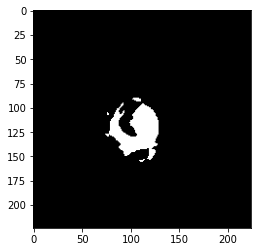

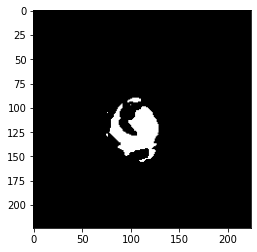

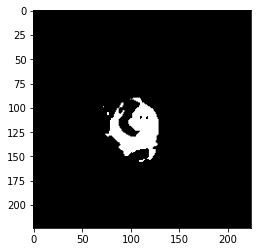

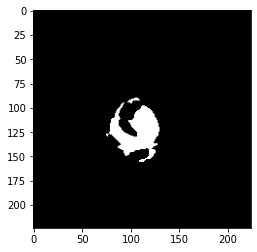

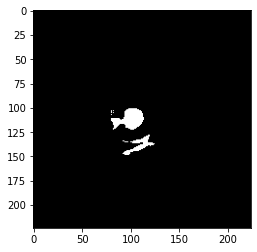

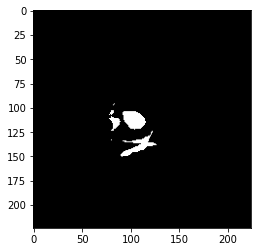

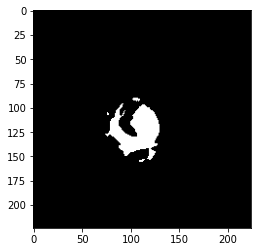

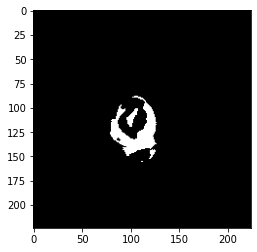

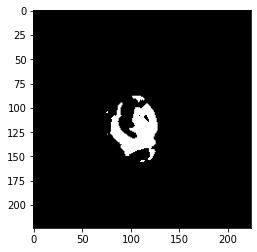

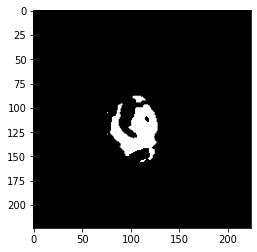

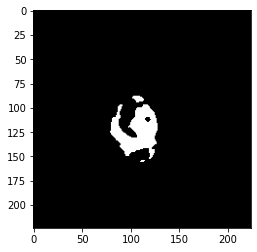

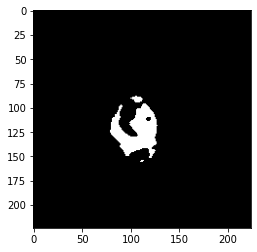

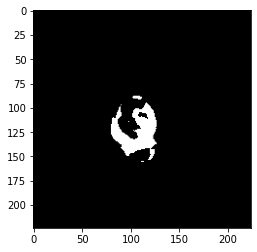

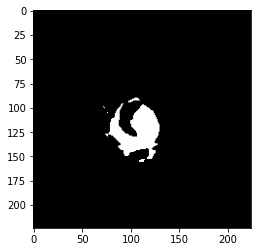

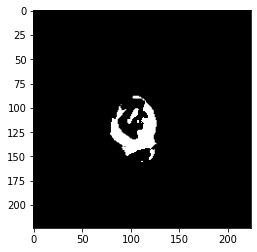

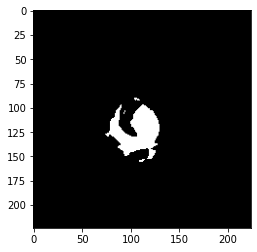

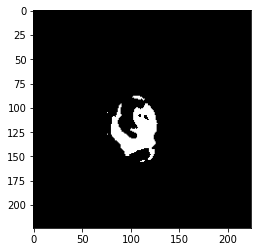

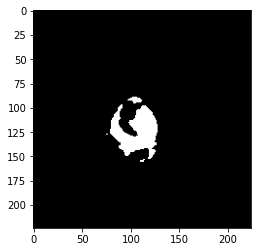

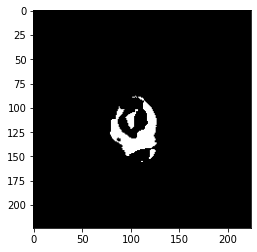

In [ ]:
for out in output[0]:
  fim = np.zeros((224, 224))
  for i in range(out.numpy()[0].shape[0]):
    for j in range(out.numpy()[0].shape[1]):
      #print(out.numpy()[0][i][j])
      if out.numpy()[0][i][j]>5:
        fim[i][j] = 255
  plt.imshow(fim, cmap='gray')
  plt.show()

# **Pre-trained UNet**

In [ ]:
model = torch.hub.load('mateuszbuda/brain-segmentation-pytorch', 'unet', in_channels=3, out_channels=1, init_features=32, pretrained=True)

Using cache found in /root/.cache/torch/hub/mateuszbuda_brain-segmentation-pytorch_master


In [ ]:
def train(model, trainloader, optimizer, criterion, device):
  model.train()

  running_loss = 0.0
  for cine, mask in tqdm(trainloader):
    optimizer.zero_grad()
    cine = cine.to(device)
    mask = mask.to(device)
  
    outputs = model(cine)
    out_flatten = nn.Flatten()
    mask_flatten = nn.Flatten()
    loss=criterion(out_flatten(outputs), mask_flatten(mask))
    running_loss+=loss.item()*cine.size(0)
    loss.backward()
    optimizer.step()
  
  epoch_loss = running_loss/len(trainloader.dataset)
  
  return epoch_loss 

In [ ]:
def eval(model, testloader, criterion, device):
  model.eval()

  with torch.no_grad():
      running_loss = 0.0
      for cine, mask in tqdm(testloader):
        
        cine = cine.to(device)
        mask = mask.to(device)
      
        outputs = model(cine)
        out_flatten = nn.Flatten()
        mask_flatten = nn.Flatten()
        loss=criterion(out_flatten(outputs), mask_flatten(mask))
        running_loss+=loss.item()*cine.size(0)
      
      epoch_loss = running_loss/len(testloader.dataset)
  
  return epoch_loss 

In [ ]:
def run(train_loader, val_loader, epochs):
    model = torch.hub.load('mateuszbuda/brain-segmentation-pytorch', 'unet', in_channels=3, out_channels=1, init_features=32, pretrained=True)
    criterion=nn.CrossEntropyLoss()
    optimizer=optim.Adam(model.parameters(), lr=0.001)
    device = torch.device("cuda" if torch.cuda.is_available() else 'cpu')
    model.to(device)

    for epoch in range(epochs):
        train_loss = train(model, train_loader, optimizer, criterion, device)
        val_loss = eval(model, val_loader, criterion, device)
        if epoch==0:
          best_loss = val_loss
          torch.save(model.state_dict(), os.path.join('/drive/MyDrive/Data_rings/Models/Pre-trained', '{0:0=2f}.pth'.format(best_loss)))

        else:
          if val_loss<best_loss:
            best_loss = val_loss
            torch.save(model.state_dict(), os.path.join('/drive/MyDrive/Data_rings/Models/Pre-trained', '{0:0=2f}.pth'.format(best_loss)))


In [ ]:
run(train_loader, val_loader, 5)

Using cache found in /root/.cache/torch/hub/mateuszbuda_brain-segmentation-pytorch_master


  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

In [ ]:
def inference(test_loader):
    model = torch.hub.load('mateuszbuda/brain-segmentation-pytorch', 'unet', in_channels=3, out_channels=1, init_features=32, pretrained=True)
    device = torch.device("cuda" if torch.cuda.is_available() else 'cpu')
    model.to(device)
    outputs=[]
    model.load_state_dict(torch.load('/drive/MyDrive/Data_rings/Models/Pre-trained/8485.720564.pth'))
    with torch.no_grad():
      for cine in tqdm(test_loader):
          cine = cine.to(device)
          #cv2_imshow(cine[0][0].detach().numpy().reshape((224, 224)))
          mask = model(cine)
          outputs.append(mask)
      

    return outputs

In [ ]:
output = inference(test_loader)

Using cache found in /root/.cache/torch/hub/mateuszbuda_brain-segmentation-pytorch_master


  0%|          | 0/1 [00:00<?, ?it/s]

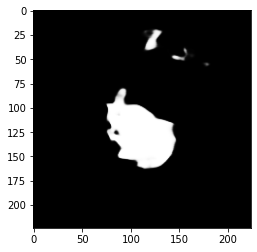

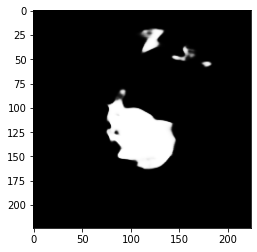

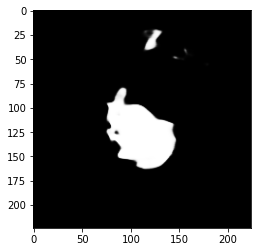

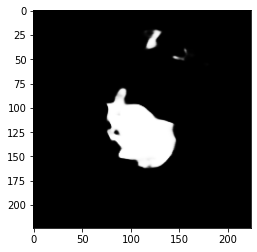

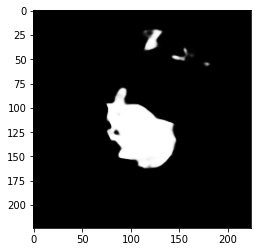

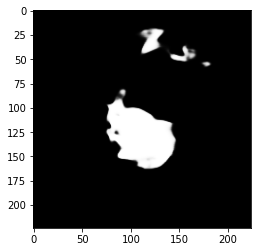

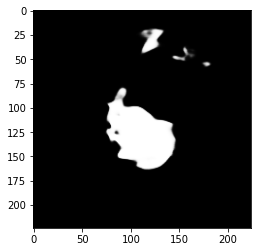

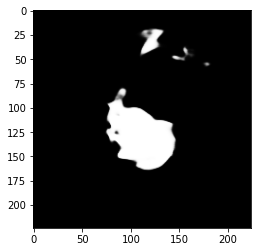

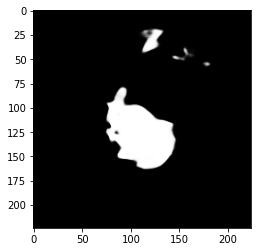

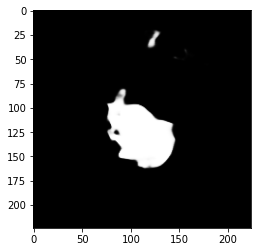

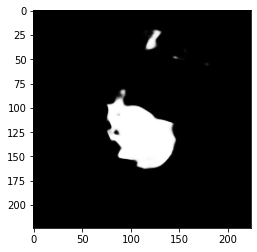

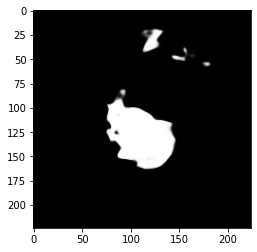

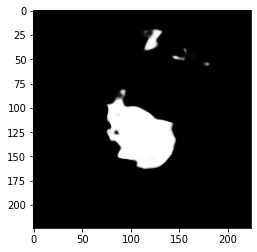

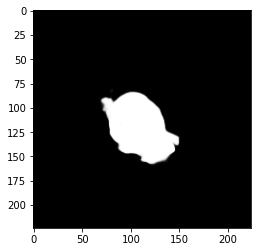

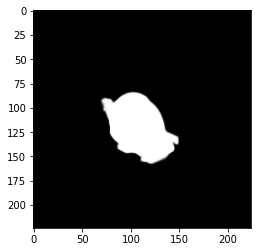

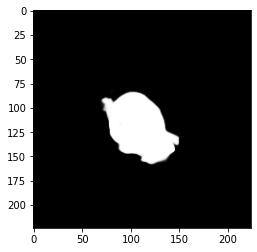

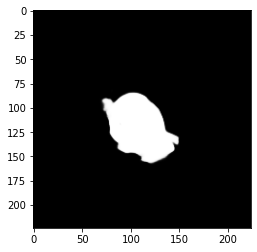

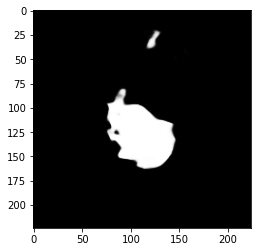

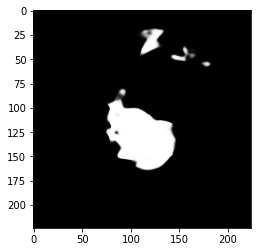

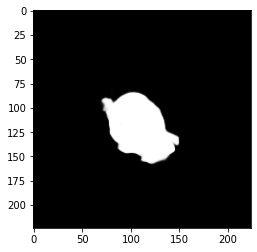

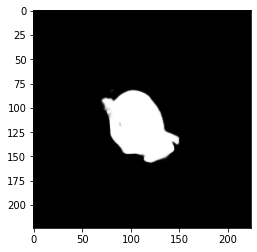

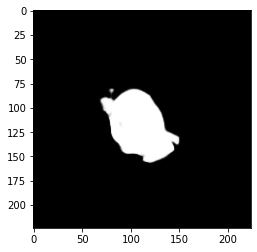

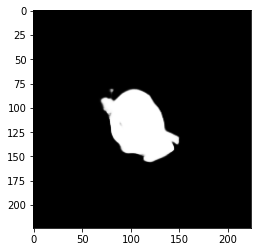

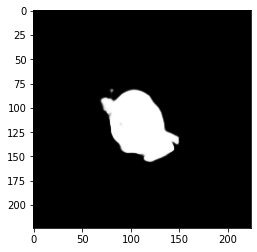

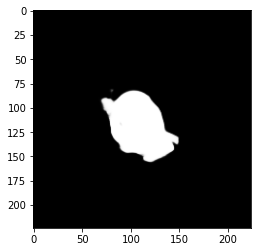

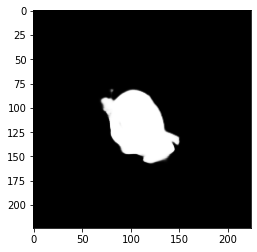

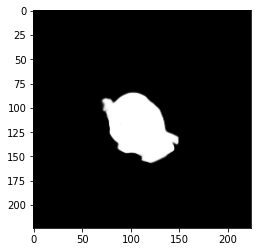

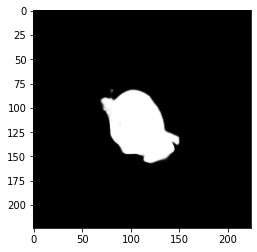

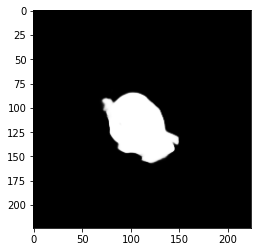

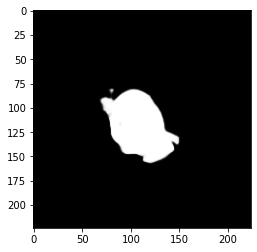

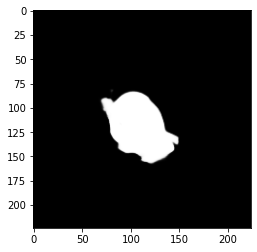

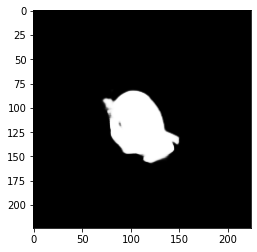

In [ ]:
for out in output[0]:
  #print(out.numpy()[0].shape)
  plt.imshow(out.numpy()[0], cmap='gray')
  plt.show()